In [1]:
import re
import random
import pandas as pd
import hashlib

In [2]:
with open('certcards2.txt', mode='r', encoding='utf8') as f:
    all_cards = f.read()
    
card_split_pattern = r'\n\n\n\d+\n'
all_cards = re.split(card_split_pattern, all_cards)
# Use re.DOTALL to allow . to match newline characters
card_pattern = re.compile(r'(.+?)\n([\s\S]+)', re.DOTALL)
cards = [(match.group(1), match.group(2)) for cstring in all_cards if (match := re.search(card_pattern, cstring))]

# removing the cards that have no content and trimming
cards = [(subject, stripped_content) for subject, content in cards if len(stripped_content := content.strip()) > 5]

def hash_string_md5(s):
    """
    Hashes a string using MD5 and returns a truncated hash for efficiency.

    Parameters:
    - s (str): The input string to hash.

    Returns:
    - str: The truncated hexadecimal hash string.
    """
    if pd.isnull(s):
        return None  # Handle NaN values gracefully
    return hashlib.md5(s.encode('utf-8')).hexdigest()


def remake_card_document(existing_cards: pd.DataFrame, filename: str='certcards2.txt'):
    with open(filename, mode='w', encoding='utf8') as f:
        i = 1
        for _, row in existing_cards.iterrows():
            f.write('\n'*6)
            f.write(str(i)+'\n')  
            f.write(row['head']+'\n')
            f.write(row['body'])
            i+=1
    print(F"Cards found: {existing_cards.shape[0]}")
    print(F"Total card age: {abs(existing_cards['age'].sum()):.2f}")


existing_cards = pd.DataFrame(cards, columns=['head', 'body'])


# existing_cards['age'] = [random.random() for _ in existing_cards.index]
existing_cards['hash'] = existing_cards['body'].apply(hash_string_md5)
existing_cards

card_ages = pd.read_json('card_ages.json')
card_ages = card_ages.drop_duplicates(subset=['hash'], keep='first')

cards_to_age = pd.merge(
    left=existing_cards,
    right=card_ages[['hash', 'age']],
    left_on='hash', right_on='hash',
    how='left'
)



cards_to_age['head'] = cards_to_age['head'].str.strip()

# remove headers I don't want anymore
undesired_headers = ['CCH Axcess']
cards_to_age = cards_to_age.loc[~cards_to_age['head'].isin(undesired_headers), :].copy()

cards_to_age['age'] = cards_to_age['age'].fillna(0)
# cards_to_age['age'] = cards_to_age['age'] * age_factor
cards_to_age['age'] = cards_to_age['age'] + [random.expovariate(.5) for _ in cards_to_age.index]
# cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1) for _ in cards_to_age.index]
if cards_to_age['age'].mean() > 80: 
    cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1.3) for _ in cards_to_age.index]

# Adding priority age growth to cards for upcoming certifications
priority_headers = ['Asynchronous Python', 'PnP PowerShell']
priority_cards_mask = cards_to_age['head'].isin(priority_headers)
cards_to_age.loc[priority_cards_mask, 'age'] = cards_to_age.loc[priority_cards_mask, 'age'] * 1.075

cards_to_age = cards_to_age.drop_duplicates(subset=['hash'], keep='first')

cards_to_age['subject_mean_age'] = cards_to_age.groupby('head')['age'].transform('mean')
cards_to_age['subject_highest_age'] = cards_to_age.groupby('head')['age'].transform('max')
cards_to_age['subject_age_sum'] = cards_to_age.groupby('head')['age'].transform('sum')
cards_to_age['head_random_roll'] = cards_to_age.groupby('head')['head'].transform(lambda x: random.random())
cards_to_age['head_count'] = cards_to_age.groupby('head')['head'].transform("count")


cards_to_age.sort_values('hash')[['age', 'head', 'hash']].to_json('card_ages.json', indent=2)

existing_cards = cards_to_age

In [3]:
ave_order = ('age', 'mean')
sum_order = ('age', 'sum')

stats = existing_cards.groupby('head').agg({'age': ['sum', 'mean', 'max'], 'head': 'count'}).sort_values(ave_order)
stats.columns = stats.columns.to_flat_index()
stats.columns = ['_'.join(col).strip() for col in stats.columns]
stats.index.name = None
stats

,age_sum,age_mean,age_max,head_count
Exchange Online and Defender,147.569067,3.783822,10.778950,39
Docker,245.041128,7.904553,16.262984,31
SSH + SCP,291.869765,10.064475,26.497255,29
GUI Docker Container,447.272594,21.298695,37.953300,21
Linux,738.515902,23.078622,38.196240,32
"Everything is Tuberculosis, Green",547.877059,23.820742,35.036276,23
WinHex,572.653547,27.269217,40.845151,21
"The Simulacra, Dick",802.496867,42.236677,70.105886,19
Windows PATH Variable,1383.877367,46.129246,97.613492,30
Node.JS and React,1895.058664,61.130925,152.703949,31


# Histogram

sum of ages: ~53903.12


<Axes: >

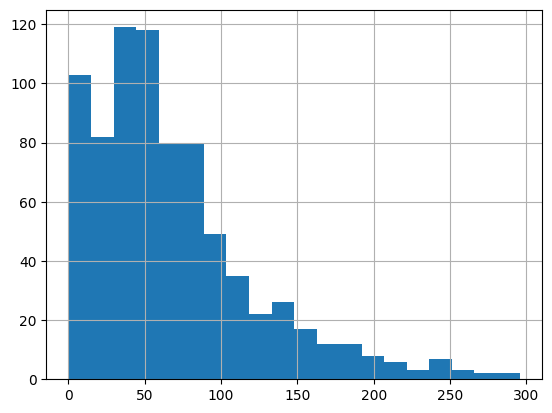

In [4]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards['age'].hist(bins=20)

sum of ages: ~53903.12


<Axes: >

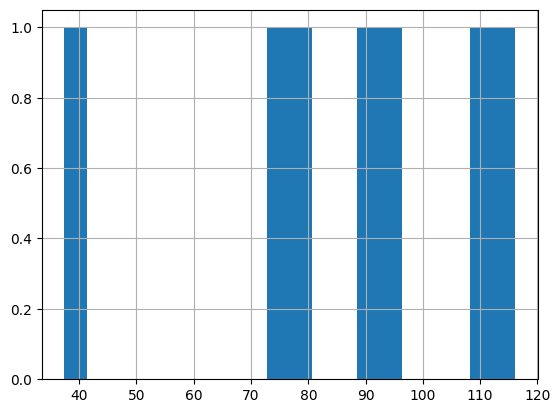

In [5]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards[existing_cards['head']=='The Starless Crown, Rollins']['age'].hist(bins=20)

# Completely Random Shuffle

In [6]:
# existing_cards = existing_cards.sample(frac=1)
# remake_card_document(filename='certcards2.txt', existing_cards = existing_cards)

# Age Sort

In [7]:
# existing_cards = existing_cards.sort_values('age', ascending=False)
# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)
# existing_cards.head(10)

# N-fold shuffle


## Age Sum

In [8]:
# n = 3
# m=existing_cards.shape[0]//100
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // m

# existing_cards['subject_age_sum'] = existing_cards['subject_age_sum'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_age_sum', 'age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Age Mean

In [9]:
# n=3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_mean_age'] = existing_cards['subject_mean_age'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_mean_age', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)

## Age Max

In [10]:
# n = random.choice([1, 2, 3, 4, 4, 5])

# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# if existing_cards['age'].sum() > 0:
#     existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['neg_age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_highest_age', 'neg_age'], inplace=True)
# # existing_cards.sort_values(['age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Card Count

In [11]:
existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()

choices = ['floor', 'mod']
option = random.choice(choices)
if option == 'floor':
    n=5
    existing_cards['n_fold'] = existing_cards['count'] // n
    print("floor dividing for n-fold")
elif option == 'mod':
    n=3
    existing_cards['n_fold'] = existing_cards['count'] % n
    print("modulo for n-fold")
else: raise NotImplementedError


if existing_cards['age'].sum() > 0:
    # existing_cards['neg_subject_highest_age'] = existing_cards['subject_highest_age'] *-1
    existing_cards['neg_age'] = existing_cards['age'] *-1
    existing_cards['subject_highest_age'] *= -1
existing_cards.sort_values(['n_fold', 'head_count', 'subject_highest_age', 'neg_age'], inplace=True)
remake_card_document(existing_cards=existing_cards)

existing_cards.head(10)

modulo for n-fold
Cards found: 786
Total card age: 53903.12


,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,head_count,count,n_fold,neg_age
164,Asynchronous Python,Non-blocking I/O\nA key feature of async Pytho...,e31c9ef75f0e70ea8d9ba7c44c74ed83,108.813096,84.986379,-108.813096,254.959138,0.233551,3,0,0,-108.813096
129,"The Starless Crown, Rollins",Orrery (OR-uh-ree)\nnoun\nA mechanical model o...,5f044c304494d6a3fa6f2b1643f42ef2,116.109143,86.613468,-116.109143,606.294279,0.865102,7,0,0,-116.109143
132,"The Starless Crown, Rollins",Wood and batten\n\nA building style using wide...,2a02149d8a60bf3c88dda4ef41eb740e,92.215671,86.613468,-116.109143,606.294279,0.865102,7,3,0,-92.215671
135,"The Starless Crown, Rollins",Coif (kwahf)\nnoun / verb\nA close-fitting cap...,d92136bac9823f10cd9fe52822bf88cb,37.398867,86.613468,-116.109143,606.294279,0.865102,7,6,0,-37.398867
101,PnP PowerShell,SharePoint CSOM (Client-Side Object Model)\nA ...,4e429af56cd1ace6b2032b1bc6474abc,287.311029,141.268213,-287.311029,1553.950344,0.848922,11,0,0,-287.311029
104,PnP PowerShell,Import-Clixml (Microsoft.PowerShell.Utility)\n...,feda79e84dbbb29b9da39f9acf4d7db1,174.289273,141.268213,-287.311029,1553.950344,0.848922,11,3,0,-174.289273
107,PnP PowerShell,JSON Payloads\nData formatted in JSON used in ...,ee62c7ee92b2eb7f167b69fbd849b1e3,93.680950,141.268213,-287.311029,1553.950344,0.848922,11,6,0,-93.680950
295,PnP PowerShell,Import-PnPProvisioningTemplate (PnP.PowerShell...,631be413fd92ed990499319481b60c4f,76.408076,141.268213,-287.311029,1553.950344,0.848922,11,9,0,-76.408076
87,Accounting,Allowance Method for Doubtful Accounts\nEstima...,8ab1c9af408775b6a1a9bd2d0c649d14,273.380278,97.081794,-273.380278,1553.308709,0.487935,16,0,0,-273.380278
90,Accounting,Audit vs. Review vs. Compilation\nLevels of fi...,05988bd0905e9974a881d23346023dcd,110.204353,97.081794,-273.380278,1553.308709,0.487935,16,3,0,-110.204353



## Random

In [12]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n
# existing_cards['age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_random_roll', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)

In [13]:
existing_cards.head(10)['age'].sum()

np.float64(1369.810736474965)

In [14]:
asc = existing_cards.age.sum() < 0

existing_cards.sort_values('age', ascending=asc).head(10)

,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,head_count,count,n_fold,neg_age
3,Node.js and Vite,vite.config.js\nVite’s main configuration file...,6579af3b0c080942dce68776aa2d8914,295.504494,96.362675,-295.504494,3950.869667,0.315465,41,0,0,-295.504494
101,PnP PowerShell,SharePoint CSOM (Client-Side Object Model)\nA ...,4e429af56cd1ace6b2032b1bc6474abc,287.311029,141.268213,-287.311029,1553.950344,0.848922,11,0,0,-287.311029
102,PnP PowerShell,Invoke-PnPRequest (PnP.PowerShell)\nSends cust...,76b6b1815c89739010ffb02cb0d2d6fd,274.314143,141.268213,-287.311029,1553.950344,0.848922,11,1,1,-274.314143
87,Accounting,Allowance Method for Doubtful Accounts\nEstima...,8ab1c9af408775b6a1a9bd2d0c649d14,273.380278,97.081794,-273.380278,1553.308709,0.487935,16,0,0,-273.380278
88,Accounting,General Ledger (GL)\nCentral accounting record...,2e1cb1792a872ef7c0655341a20c8431,260.695593,97.081794,-273.380278,1553.308709,0.487935,16,1,1,-260.695593
10,Microsoft Purview,"You can configure your policies so that, when ...",1bc3c328bf07dac54524eadc58cfa328,260.635393,86.468951,-260.635393,3891.102796,0.326418,45,0,0,-260.635393
31,Django,Django App\nA self-contained feature module (e...,369de91dbb3f2242f251cc46ac43faac,259.071133,81.833127,-259.071133,3273.325073,0.845212,40,0,0,-259.071133
80,TSQL,Q: What does SUM(x) OVER (PARTITION BY y) do?\...,dda5b7601f3b5593f784810dd25436e7,248.951766,99.335669,-248.951766,1688.706374,0.212352,17,0,0,-248.951766
24,Terraform Codebox,corepack pnpm test\nA command pattern used to ...,85012d4ed6b5e32d36886a085cc48197,244.843946,100.546766,-244.843946,3619.683571,0.515804,36,0,0,-244.843946
25,Terraform Codebox,Lifecycle blocks let you fine-tune resource be...,0f442d63063c2560ae76af631c6b9d12,241.293588,100.546766,-244.843946,3619.683571,0.515804,36,1,1,-241.293588


In [15]:
f"Average age: {abs(existing_cards['age'].mean()):.3f}"

'Average age: 68.579'